### **1. Importing necessary libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from utils.utils import plot_confusion_matrix, split_data

2024-04-10 14:23:30.568803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 14:23:31.304770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### **2. CNN Model**

In [2]:
# loading model
model = keras.models.load_model('./models/trained/cnn_model.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 96800)             0         
                                                                 
 dense (Dense)               (None, 1)                 9

2024-04-10 14:23:32.377294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 14:23:32.406425: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# loading model's history
with open('./models/historys/cnn_model_history', 'rb') as f:
    history = pickle.load(f)

#### 2.1 Curves

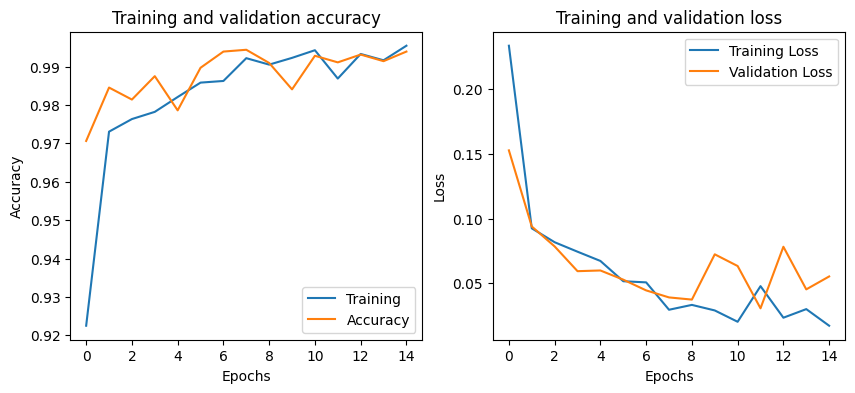

In [4]:
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training", "Accuracy"])

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])

plt.savefig('./models/figures/cnn/CNN-curves.jpg')

plt.show()

#### 2.2 Loading datas

In [5]:
#load dataset
dataset = pd.read_csv('../dataset/dataset_final.csv')

# refactor values in filepath column added ../ to the path
dataset['Filepath'] = dataset['Filepath'].apply(lambda x: '../' + x)

dataset.head()

,Filepath,Label
0,../dataset/Positive/07045.jpg,POSITIVE
1,../dataset/Positive/09452.jpg,POSITIVE
2,../dataset/Positive/19030_1.jpg,POSITIVE
3,../dataset/Negative/06463.jpg,NEGATIVE
4,../dataset/Positive/12625_1.jpg,POSITIVE


In [6]:
train_df, test_df = train_test_split(
    dataset.sample(frac=1.0, random_state=42),
    train_size=0.80,
    random_state=42
)

In [7]:
train_data, validation_data, test_data = split_data(train_df, test_df)

Found 25600 validated image filenames belonging to 2 classes.


Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


#### 2.3 Testing the model

In [8]:
y_pred = np.squeeze(model.predict(test_data) >= 0.5).astype(np.int32)

250/250 [==============================] - 11s 44ms/step


In [9]:
from sklearn.metrics import f1_score, precision_score, recall_score

x = f1_score(test_data.labels, y_pred)
y = precision_score(test_data.labels, y_pred)
z = recall_score(test_data.labels, y_pred)

In [10]:
print(f'F1 Score: {round(x*100,2)}%')
print(f'Precision Score: {round(y*100,2)}%')
print(f'Recall Score: {round(z*100,2)}%')

F1 Score: 98.63%
Precision Score: 99.57%
Recall Score: 97.71%


In [11]:
results = model.evaluate(test_data)

# assigning the results into loss and accuracy
loss = results[0]
accuracy = results[1]

# showing up the results
print(f"Model's accuracy: {(accuracy*100):0.2f}%")
print(f"Model's loss: {(loss):0.2f}")

250/250 [==============================] - 12s 46ms/step - loss: 0.0426 - accuracy: 0.9864
Model's accuracy: 98.64%
Model's loss: 0.04


               precision    recall  f1-score   support

Without crack       0.98      1.00      0.99      3981
   With crack       1.00      0.98      0.99      4019

     accuracy                           0.99      8000
    macro avg       0.99      0.99      0.99      8000
 weighted avg       0.99      0.99      0.99      8000



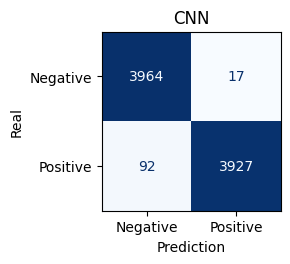

In [12]:
# creating the confusion matrix
classifications = classification_report(test_data.labels, y_pred, target_names = ["Without crack", "With crack"])

print(classifications)

# ploting the Matrix
disp = plot_confusion_matrix(test_data.labels, y_pred, title="CNN")

In [13]:
disp.figure_.savefig('./models/figures/cnn/CNN-confusion-matrix_final.png')
disp.figure_.savefig('./models/figures/cnn/CNN-confusion-matrix_final.eps')